In [1]:
import os
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.utils.class_weight import compute_class_weight

In [2]:
is_phonetic = True

paths = [
    "/home/toure215/BERT_phonetic/DATASETS/verses/verses_hf",
    "/home/toure215/BERT_phonetic/DATASETS/verses/phonetic_verse_hf",
]

models = [
    "bert-base-uncased",
    "psktoure/BERT_BPE_phonetic_wikitext-103-raw-v1",
]

In [3]:
idx = 0
if is_phonetic:
    idx = 1

In [4]:
dataset = load_from_disk(paths[idx])
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'Verse', 'Meter', 'label', 'Original'],
        num_rows: 161190
    })
    test: Dataset({
        features: ['id', 'Verse', 'Meter', 'label', 'Original'],
        num_rows: 19901
    })
    validation: Dataset({
        features: ['id', 'Verse', 'Meter', 'label', 'Original'],
        num_rows: 17911
    })
})

In [5]:
model = AutoModelForSequenceClassification.from_pretrained("models/rhyme_bert")
tokenizer = AutoTokenizer.from_pretrained(models[idx])

In [6]:
model.eval()
model.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
def forward_function(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    logits = outputs.logits
    return torch.softmax(logits, dim=-1)

In [8]:
def preprocess_input(text):
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    inputs = {k: v.cuda() for k, v in inputs.items()}
    embeddings = model.get_input_embeddings()(inputs["input_ids"])
    return inputs, embeddings

In [9]:
from captum.attr import IntegratedGradients


def get_attributions(text, target_class):
    inputs, embeddings = preprocess_input(text)

    ig = IntegratedGradients(forward_function)

    attributions, delta = ig.attribute(
        inputs=embeddings,
        additional_forward_args=(inputs["attention_mask"],),
        target=target_class,
        return_convergence_delta=True,
    )
    return attributions, inputs

In [10]:
import matplotlib.pyplot as plt


def visualize_attributions(text, attributions, inputs):
    print(attributions.shape)
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    attributions = attributions / np.linalg.norm(attributions)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    plt.figure(figsize=(12, 4))
    plt.bar(tokens, attributions, color="blue", alpha=1)
    plt.xticks(rotation=45)
    plt.xlabel("Tokens")
    plt.ylabel("Attribution Score")
    plt.title(f"Token Attribution Scores on : {text}")
    plt.show()

torch.Size([1, 16, 768])


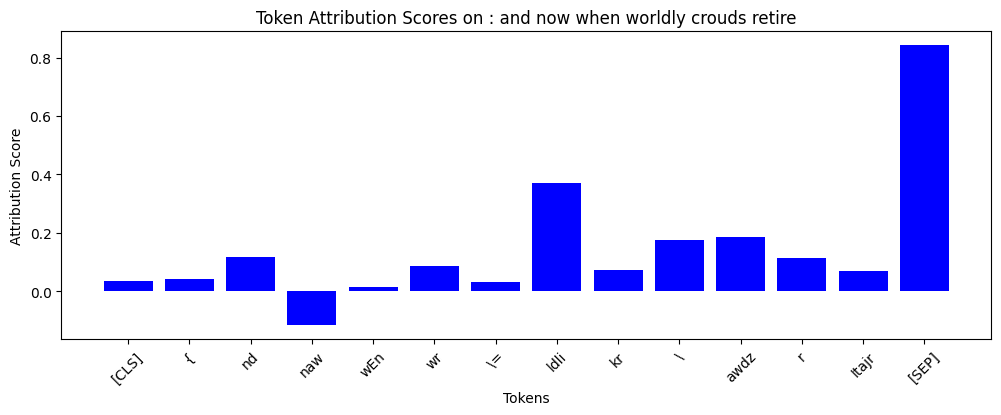

In [11]:
idx = 1
text, label = dataset["test"][idx]["Verse"], dataset["test"][idx]["label"]
original_text = dataset["test"][idx]["Original"]
target_class = torch.tensor([label]).cuda()

attributions, inputs = get_attributions(text, target_class)

visualize_attributions(original_text, attributions, inputs)

In [33]:
from captum.attr import IntegratedGradients, visualization, LayerIntegratedGradients
import torch


def forward_function(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    logits = outputs.logits
    return torch.softmax(logits, dim=-1)


def preprocess_input(text):
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=32
    )
    inputs = {k: v.cuda() for k, v in inputs.items()}
    embeddings = model.get_input_embeddings()(inputs["input_ids"])
    return inputs, embeddings


def get_attributions(text, target_class):
    inputs, embeddings = preprocess_input(text)

    ref_input_ids = torch.ones_like(inputs["input_ids"]) * tokenizer.pad_token_id
    ref_input_ids[:, 0] = tokenizer.cls_token_id
    ref_input_ids[:, -1] = tokenizer.sep_token_id
    ref_input_ids = ref_input_ids.unsqueeze(-1).cuda()

    ig = LayerIntegratedGradients(forward_function, model.bert.embeddings)
    attributions, delta = ig.attribute(
        inputs=embeddings,
        baselines=ref_input_ids,
        n_steps=50,
        additional_forward_args=(inputs["attention_mask"],),
        target=target_class,
        return_convergence_delta=True,
    )
    return attributions, inputs, delta


def create_visualization_record(attributions, inputs, delta, target_class):
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    attributions = attributions / np.linalg.norm(attributions)

    outputs = model(
        inputs_embeds=model.get_input_embeddings()(inputs["input_ids"]),
        attention_mask=inputs["attention_mask"],
    )
    logits = outputs.logits
    pred_class = logits.argmax(dim=-1).item()

    idx_to_label = {0: "iambic", 1: "anapaestic", 2: "trochaic", 3: "dactyl"}
    pred_label = idx_to_label[pred_class]
    target_label = idx_to_label[target_class]

    raw_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    record = visualization.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=torch.softmax(logits, dim=-1)[0][pred_class].item(),
        pred_class=pred_label,
        attr_class=pred_label,
        true_class=target_label,
        attr_score=attributions.sum(),
        raw_input_ids=raw_tokens,
        convergence_score=delta,
    )
    return record


def visualize_attributions(record):
    visualization.visualize_text([record])

In [34]:
# idx = 1
# text, label, original_text = (
#     dataset["test"][idx]["Verse"],
#     dataset["test"][idx]["label"],
#     dataset["test"][idx]["Original"],
# )
# target_class = label

# attributions, inputs, delta = get_attributions(text, target_class)

# record = create_visualization_record(attributions, inputs, delta, target_class)

# print(inputs["input_ids"][0].tolist())
# print(original_text)

# visualize_attributions(record)

In [35]:
idx_to_label = {0: "iambic", 1: "anapaestic", 2: "trochaic", 3: "dactyl"}

for label in idx_to_label.keys():
    records = []
    idx = 0
    for row in dataset["test"]:
        if idx == 5:
            break

        target_class = row["label"]
        if target_class != label:
            continue
        text = row["Verse"]
        original_text = row["Original"]
        print(f"Original {idx_to_label[label]} verse: {original_text}")
        attributions, inputs, delta = get_attributions(text, target_class)
        record = create_visualization_record(attributions, inputs, delta, target_class)
        records.append(record)
        idx += 1

    visualization.visualize_text(records)

Original iambic verse: and heaven's own thunders roll
Original iambic verse: and now when worldly crouds retire
Original iambic verse: not more lamented than thy virtuous son
Original iambic verse: this night to feast with corydon i go
Original iambic verse: and why see that why thought to toil and eat


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
iambic,trochaic (0.51),trochaic,0.82,[CLS] { nd hiv Inz own TVndr \= z r \ owl [SEP]
iambic,iambic (0.97),iambic,2.25,[CLS] { nd naw wEn wr \= ldli kr \ awdz r \ Itajr \ [SEP]
iambic,trochaic (0.96),trochaic,-2.05,[CLS] nAt mOr \ l @ mEntId D { n Daj vr \= tSu @ s sVn [SEP]
iambic,iambic (0.83),iambic,1.76,[CLS] DIs najt t @ fist wID kOr \ id @ n aj gow [SEP]
iambic,anapaestic (0.87),anapaestic,1.76,[CLS] { nd waj si D { t waj TOt t @ tojl { nd it [SEP]


Original anapaestic verse: should words e'er be wanting to speak out more clear
Original anapaestic verse: might learn from the wisdom of age
Original anapaestic verse: and deck'd the sod seats at her door
Original anapaestic verse: 'tis you that must board and 'tis you that must bed
Original anapaestic verse: you also have tetrameter and pentameter


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
anapaestic,anapaestic (0.97),anapaestic,2.17,[CLS] SUd wr \= dz Er \= bi wAntIN t @ spik awt mOr \ klIr \ [SEP]
anapaestic,anapaestic (0.90),anapaestic,2.06,[CLS] majt lr \= n fr \ Vm D @ wIzd @ m Vv ejdZ [SEP]
anapaestic,anapaestic (0.74),anapaestic,1.53,[CLS] { nd dEk d D @ sAd sits { t hr \= dOr \ [SEP]
anapaestic,anapaestic (0.78),anapaestic,2.43,[CLS] tIs ju D { t mVst bOr \ d { nd tIs ju D { t mVst bEd [SEP]
anapaestic,anapaestic (1.00),anapaestic,3.15,[CLS] ju Olsow h { v tEtr \{ m @ tr \= { nd pEnt { m @ tr \= [SEP]


Original trochaic verse: while my busy thoughts i rear
Original trochaic verse: guided by the pow'rs above
Original trochaic verse: think not she whose empty pride
Original trochaic verse: ruffians pittiless as proud
Original trochaic verse: see from yonder hill descending


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
trochaic,trochaic (0.97),trochaic,1.11,[CLS] wajl maj bIzi TOts aj r \ Ir \ [SEP]
trochaic,trochaic (0.95),trochaic,1.67,[CLS] gajd @ d baj D @ pawr \= z @ bVv [SEP]
trochaic,trochaic (0.79),trochaic,1.11,[CLS] TINk nAt Si huz Empti pr \ ajd [SEP]
trochaic,trochaic (0.64),trochaic,2.49,[CLS] r \ Vfaj @ nz pIt ajl @ s { z pr \ awd [SEP]
trochaic,trochaic (0.99),trochaic,1.51,[CLS] si fr \ Vm jAndr \= hIl dIsEndIN [SEP]


Original dactyl verse: whir of wings in the drowsy air and the cooing of pigeons
Original dactyl verse: breathed like the evening wind and whispered love to the maiden
Original dactyl verse: like the sweet thoughts of love on a darkened and devious spirit
Original dactyl verse: no king george of england shall drive you away from your homesteads
Original dactyl verse: all her o'erburdened heart gave way and she wept and lamented
